In [ ]:
#Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Exploring data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

## 1.1. Image Classification task

In [ ]:
task1_dataset = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Image_Classification/dataset_24681189'

In [ ]:
# Modify input shape and batch size if necessary
input_shape = (224, 224)
batch_size = 32

# Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


generator = datagen.flow_from_directory(
    task1_dataset,
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Number of classes
n_classes = len(generator.class_indices)

Found 3142 images belonging to 20 classes.


In [ ]:
def show_batch(generator):
  """
  Show a batch of images from the generator.
  """
  class_indices = generator.class_indices
  class_names = list(class_indices.keys())
  num_classes = len(class_names)

  # Get file paths and their labels
  filepaths = generator.filepaths
  labels = generator.labels

  # Map class index to list of image file paths
  class_to_images = {i: [] for i in range(num_classes)}
  for path, label in zip(filepaths, labels):
      class_to_images[label].append(path)

  # Show one sample per class
  plt.figure(figsize=(15, 8))
  for idx in range(num_classes):
      if len(class_to_images[idx]) > 0:
          img_path = class_to_images[idx][0]  # First image of the class
          img = plt.imread(img_path)

          ax = plt.subplot(2, (num_classes + 1) // 2, idx + 1)
          plt.imshow(img)
          plt.title(f"{class_names[idx]}")
          plt.axis("off")

  plt.tight_layout()
  plt.show()

  # Report class distribution
  print("\nClass distribution:")
  for idx, name in enumerate(class_names):
      count = len(class_to_images[idx])
      print(f"- {name}: {count} images")

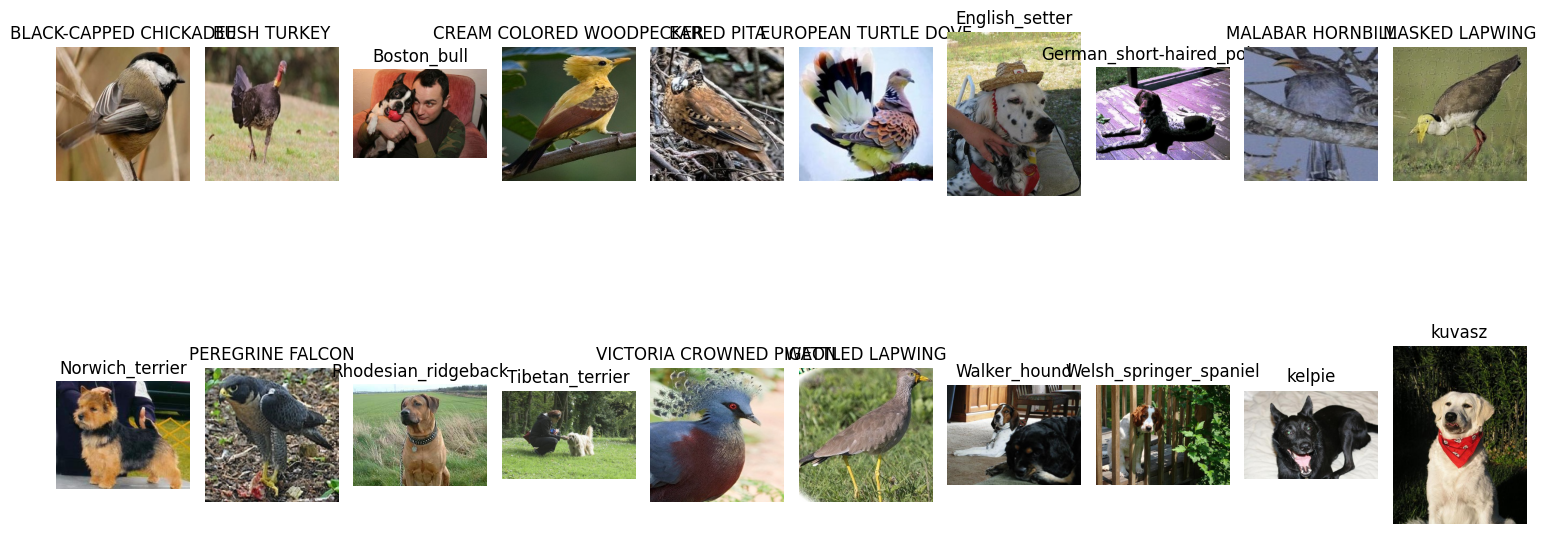


Class distribution:
- BLACK-CAPPED CHICKADEE: 138 images
- BUSH TURKEY: 156 images
- Boston_bull: 182 images
- CREAM COLORED WOODPECKER: 144 images
- EARED PITA: 153 images
- EUROPEAN TURTLE DOVE: 143 images
- English_setter: 161 images
- German_short-haired_pointer: 152 images
- MALABAR HORNBILL: 154 images
- MASKED LAPWING: 136 images
- Norwich_terrier: 185 images
- PEREGRINE FALCON: 154 images
- Rhodesian_ridgeback: 172 images
- Tibetan_terrier: 206 images
- VICTORIA CROWNED PIGEON: 153 images
- WATTLED LAPWING: 147 images
- Walker_hound: 153 images
- Welsh_springer_spaniel: 150 images
- kelpie: 153 images
- kuvasz: 150 images


In [ ]:
#Visualize samples from train generator
show_batch(generator)

## 1.2. Object Detection task

In [ ]:
task2_dataset = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo'

In [ ]:
def show_sample_images(subset='train', num_samples=5):
  """
  Displays a set of sample images and their corresponding YOLO-format label annotations.

  PARAMS:
    - subset(str): The dataset subset to visualize. Should be one of 'train', 'valid', or 'test'.
    - num_samples(int): The number of sample images to display from the specified subset.
  """
  image_dir = os.path.join(task2_dataset, subset, 'images')
  label_dir = os.path.join(task2_dataset, subset, 'labels')

  image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])[:num_samples]

  for img_file in image_files:
      img_path = os.path.join(image_dir, img_file)
      label_path = os.path.join(label_dir, img_file.rsplit('.', 1)[0] + '.txt')

      # Load and display the image
      image = Image.open(img_path)
      plt.imshow(image)
      plt.title(f"{subset.upper()} Image: {img_file}")
      plt.axis('off')
      plt.show()

      # Show corresponding YOLO labels
      print(f"YOLO Label for {img_file}:")
      if os.path.exists(label_path):
          with open(label_path, 'r') as f:
              print(f.read())
      else:
          print("Label file not found.")

In [ ]:
for split in ['train', 'valid', 'test']:
    print(f"Checking'{split}' subset:")
    show_sample_images(subset=split, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def count_images_in_splits(base_path):
    """
    Count number of images in train, test, and validation folders.

    PARAMS:
    - base_path (str): Root folder containing 'train', 'test', 'valid' splits.

    RETURNS:
    - Dictionary with counts for each split.
    """
    base_path = Path(base_path)
    splits = ['train', 'test', 'valid']
    counts = {}

    for split in splits:
        split_path = base_path / split / "images"  # images inside images/ folder
        if split_path.exists():
            image_files = list(split_path.glob("*.jpg")) + list(split_path.glob("*.png"))
            counts[split] = len(image_files)
        else:
            counts[split] = 0  # If the folder doesn't exist, count as 0

    return counts

In [ ]:
counts = count_images_in_splits(task2_dataset)

print("Dataset Split Counts:")
for split, count in counts.items():
    print(f"- {split.capitalize()}: {count} images")

Dataset Split Counts:
- Train: 1435 images
- Test: 307 images
- Valid: 307 images


# 2. Resnet18 baseline model


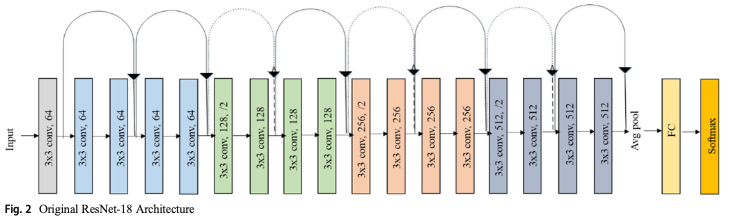

In [15]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.models import resnet18
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model
from torchview import draw_graph
from IPython.display import Image, display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


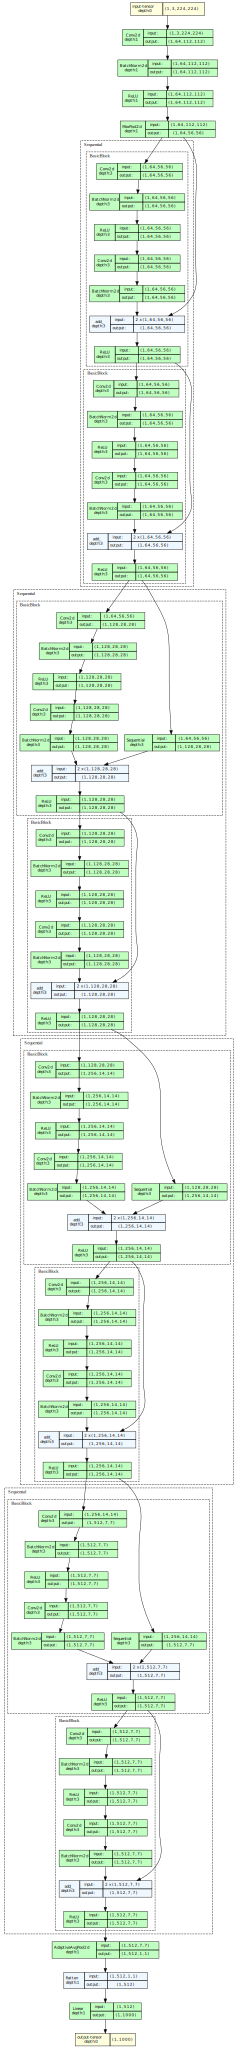

In [ ]:
from torchview import draw_graph
from torchvision.models import resnet18

model = resnet18()
batch_size = 32
model_graph = draw_graph(model, input_size=(1, 3, 224, 224), expand_nested=True)

model_graph.visual_graph

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
task1_dataset = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Image_Classification/dataset_24681189'
dataset = ImageFolder(root=task1_dataset, transform=transform)
num_classes = len(dataset.classes)

In [ ]:
# Calculate lengths
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = test_size = int(0.1 * total_size)
print(f"Total size: {total_size}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

# NO REMAINDERS
remainder = total_size - (train_size + val_size + test_size)
train_size += remainder

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Total size: 3142
Train size: 2513
Validation size: 314
Test size: 314


In [ ]:
#DataLoader(PyTorch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def get_resnet18_model():
    """
    A pretrained ResNet18 model
    """
    model = resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = True
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.Linear(256, num_classes)
    )
    return model

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss:.4f} - Train Acc: {acc:.2f}%")

In [ ]:
def evaluate(model, data_loader, device, mode='Test'):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"{mode} Accuracy: {acc:.2f}%")
    return acc


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exp1_model = get_resnet18_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exp1_model.parameters(), lr=0.001)
print("--------------------------TRAINING-----------------------")
train_model(exp1_model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
print("--------------------------EVALUATION-----------------------")
evaluate(exp1_model, test_loader, device, mode='Test')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


--------------------------TRAINING-----------------------
Epoch 1/10 - Loss: 86.5542 - Train Acc: 68.06%
Epoch 2/10 - Loss: 49.6497 - Train Acc: 81.11%
Epoch 3/10 - Loss: 30.2806 - Train Acc: 88.23%
Epoch 4/10 - Loss: 28.6686 - Train Acc: 89.46%
Epoch 5/10 - Loss: 18.2689 - Train Acc: 93.16%
Epoch 6/10 - Loss: 18.6603 - Train Acc: 93.40%
Epoch 7/10 - Loss: 16.9954 - Train Acc: 93.99%
Epoch 8/10 - Loss: 14.4775 - Train Acc: 94.63%
Epoch 9/10 - Loss: 8.5852 - Train Acc: 96.78%
Epoch 10/10 - Loss: 10.0980 - Train Acc: 96.06%
--------------------------EVALUATION-----------------------
Test Accuracy: 84.71%


84.71337579617834

In [ ]:
# Save model in to folder
!cd /content/drive/MyDrive/42028AUT2025/Assignment2
torch.save(exp1_model.state_dict(), 'exp1_model.pth')

In [ ]:
# Prediction
def predict(model, data_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())

    return predictions

In [ ]:
# Predict
predictions = predict(exp1_model, test_loader, device)

<Figure size 10000x10000 with 0 Axes>

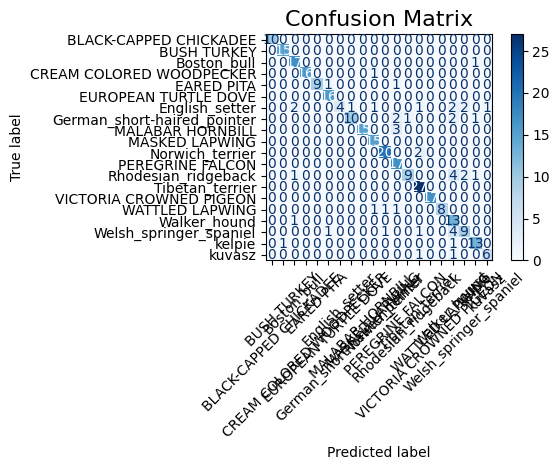

In [ ]:
predicted_classes = np.array(predictions)
true_classes = [dataset.targets[i] for i in test_dataset.indices]
class_names = list(dataset.class_to_idx.keys())
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(100, 100))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# 3. Customized ResNet18 model

In [12]:
def get_custom_resnet18_model(num_classes):
    """
    Create a custom ResNet18 with 1 residual blocks removed and a custom classifier head.
    Params:
    - num_classes (int): The number of classes in the classification task.

    Returns:
    - model (nn.Module): The customized ResNet18 model. This model will keeps the based Residual CNN layers. The only I changed in this structure
                         is the fully connected layers. The dataset contains only 20 classes of samples, hence, I want to reduce its complexity by
                         using Dropouts and ReLU activation function.

                         In addition, based on the requirements that I have to train all the weights, hence I unfreeze all the layers.
    """
    model = resnet18(pretrained=True)

    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True

    # Remove blocks
    model.layer2 = nn.Sequential(*list(model.layer2.children())[:-1])
    model.layer3 = nn.Sequential(*list(model.layer3.children())[:-1])  # Keep 1 block instead of 2
    model.layer4 = nn.Sequential(*list(model.layer4.children())[:-1])  # Keep 1 block instead of 2

    # Custom FC head
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )

    return model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


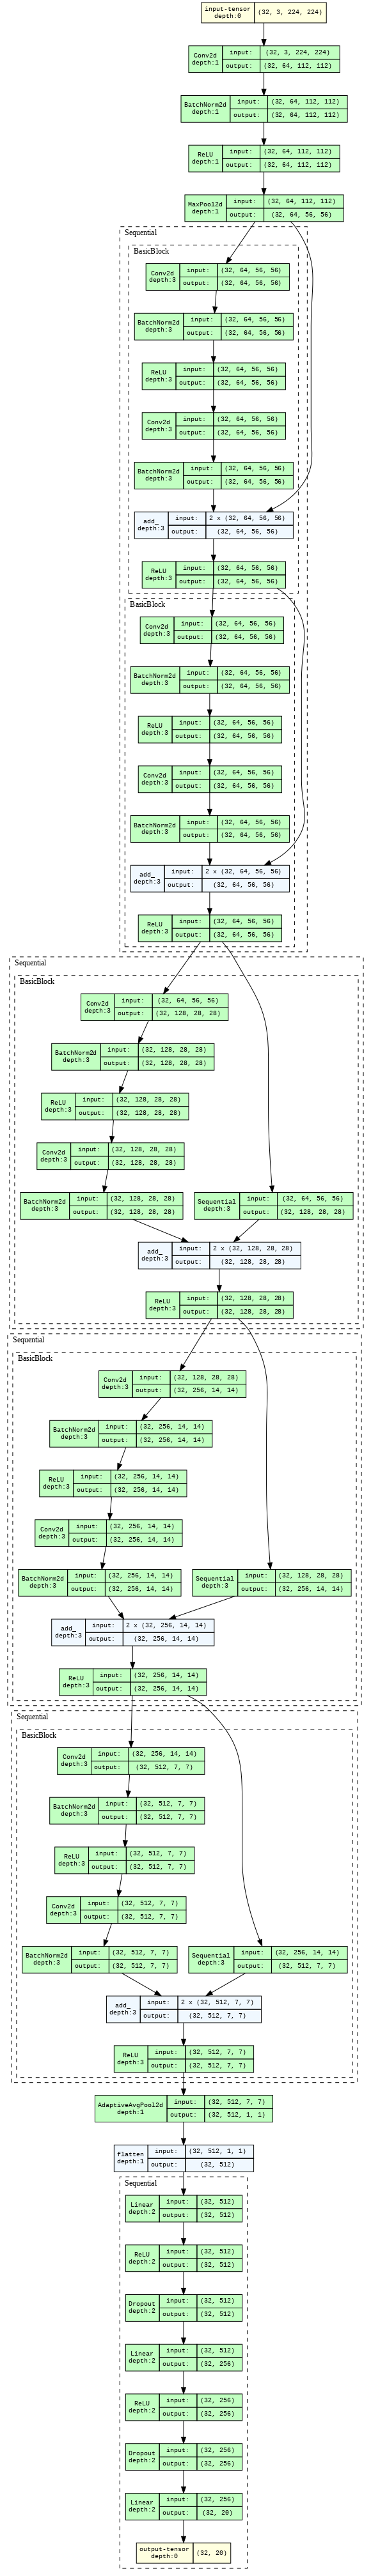

In [18]:
exp2_model = get_custom_resnet18_model(num_classes=20)
model_graph = draw_graph(exp2_model, input_size=(32, 3, 224, 224), expand_nested=True, graph_dir="TB")
model_graph.visual_graph.render("resnet18_custom_graph", format="png")
display(Image(filename="resnet18_custom_graph.png"))

In [20]:
del Image
from PIL import Image

In [22]:
img = Image.open("resnet18_custom_graph.png")  # or your actual filename
width, height = img.size

# Split in half vertically
top_half = img.crop((0, 0, width, height // 2))
bottom_half = img.crop((0, height // 2, width, height))

# Save the halves
top_half.save("resnet_backbone_part1.png")
bottom_half.save("resnet_classifier_part2.png")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(dataset.classes)
exp2_model = get_custom_resnet18_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exp2_model.parameters(), lr=0.001)
print("--------------------------TRAINING-----------------------")
train_model(exp2_model, train_loader, val_loader, criterion, optimizer, device, epochs=10)
print("--------------------------EVALUATION-----------------------")
evaluate(exp2_model, test_loader, device, mode='Test')

NameError: name 'torch' is not defined

In [ ]:
predictions = predict(exp2_model, test_loader, device)

In [ ]:
predicted_classes = np.array(predictions)
true_classes = [dataset.targets[i] for i in test_dataset.indices]
class_names = list(dataset.class_to_idx.keys())
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(100, 100))
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

class_labels = list(dataset.class_to_idx.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(exp2_model.history['accuracy'])
plt.plot(exp2_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(exp2_model.history['loss'])
plt.plot(exp2_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 4. Fast R-CNN model


In [ ]:
!pip install pycocotools
!pip install torchview
import os
import random
import xml.etree.ElementTree as ET
import torch
from PIL import Image
from torchview import draw_graph
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.nn as nn
import torch
import time
from tqdm import tqdm
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.ops import box_iou
from torchvision.models.detection._utils import Matcher
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from matplotlib.lines import Line2D
from pathlib import Path
import cv2


In [ ]:
class PascalVOCDataset(Dataset):
  """
  Custom Dataset for Pascal VOC-style XML annotations.
  To read images and bounding boxes and prepare for Fast R-CNN model.

  PARAMS:
  - root (str): The root directory containing the images and annotations.
  - transforms (callable, optional): Optional transform to be applied on a sample.
  """
  def __init__(self, root, transforms=None):
      self.root = root
      self.transforms = transforms
      self.imgs = [
          f for f in os.listdir(root)
          if f.endswith('.jpg') and os.path.exists(os.path.join(root, f.replace('.jpg', '.xml')))
      ]
      self.imgs.sort()

  def __getitem__(self, idx):
      # Image
      img_filename = self.imgs[idx]
      img_path = os.path.join(self.root, img_filename)
      img = Image.open(img_path).convert("RGB")

      # Annotation (same base name, but .xml)
      annot_filename = img_filename.replace('.jpg', '.xml')
      annot_path = os.path.join(self.root, annot_filename)

      boxes = []
      labels = []

      tree = ET.parse(annot_path)
      root = tree.getroot()

      for obj in root.findall('object'):
          label = obj.find('name').text
          labels.append(1)

          bndbox = obj.find('bndbox')
          xmin = float(bndbox.find('xmin').text)
          ymin = float(bndbox.find('ymin').text)
          xmax = float(bndbox.find('xmax').text)
          ymax = float(bndbox.find('ymax').text)
          boxes.append([xmin, ymin, xmax, ymax])

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)
      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

      target = {
          'boxes': boxes,
          'labels': labels,
          'image_id': image_id,
          'area': area,
          'iscrowd': iscrowd
      }

      if self.transforms:
          img = self.transforms(img)

      return img, target

  def __len__(self):
      return len(self.imgs)

In [ ]:
exp3_path = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/pascal/train'
dataset = PascalVOCDataset(exp3_path, transforms=ToTensor())

# Sampling an image
img, target = dataset[0]
print("Image shape:", img.shape)
print("Target:", target)

Image shape: torch.Size([3, 600, 800])
Target: {'boxes': tensor([[245.0000,   0.0000, 580.0000, 110.0000],
        [179.5000,  64.0000, 563.5000, 410.0000]]), 'labels': tensor([1, 1]), 'image_id': tensor([0]), 'area': tensor([ 36850., 132864.]), 'iscrowd': tensor([0, 0])}


In [ ]:
def visualize_pascal_voc_sample(image_dir, index=None):
    """
    Visualize a sample Pascal VOC image with bounding boxes and class names.

    Parameters:
    - image_dir (str or Path): Path to folder containing Pascal VOC .jpg and .xml files.
    - index (int, optional): Index of image to visualize. Random if None.
    """
    image_dir = Path(image_dir)
    img_files = sorted(list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png")))
    xml_files = sorted(list(image_dir.glob("*.xml")))

    if not img_files or not xml_files:
        print("No image or XML files found.")
        return

    if index is None:
        index = random.randint(0, len(img_files) - 1)

    img_path = img_files[index]
    xml_path = image_dir / (img_path.stem + ".xml")
    if not xml_path.exists():
        print(f"XML label for {img_path.name} not found.")
        return

    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Parse XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)
    ax.set_title(f"Pascal VOC Image: {img_path.name}")

    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, name, color='white', fontsize=10, backgroundcolor='red')

    ax.axis("off")
    plt.show()

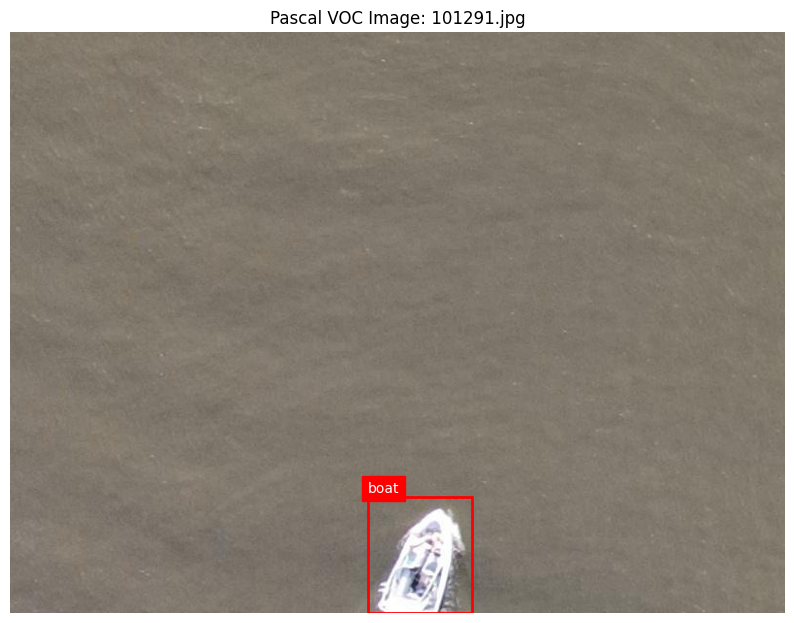

In [ ]:
visualize_pascal_voc_sample(exp3_path)


In [ ]:
exp3_path = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/pascal'

train_path = f"{exp3_path}/train"
valid_path = f"{exp3_path}/valid"
test_path  = f"{exp3_path}/test"

# Create datasets
train_ds = PascalVOCDataset(train_path, transforms=ToTensor())
valid_ds = PascalVOCDataset(valid_path, transforms=ToTensor())
test_ds  = PascalVOCDataset(test_path, transforms=ToTensor())

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
def fscnn_model(num_classes=None):
  """
  Loads a pretrained Faster R-CNN model and replaces the classifier head
  to match the number of target classes.

  PARAMS:
  - num_classes(int): Number of object classes (excluding background). Add 1 for background class.

  RETURNS:
  - model(torchvision.models.detection.FasterRCNN)
  """
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)         # Load a pretrained Fast R-CNN model
  in_features = model.roi_heads.box_predictor.cls_score.in_features                     # Get number of input features for the classifier
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)           # Replace the pre-trained FC layers (heads) to match with the specification of the dataset
  return model

In [ ]:
model = fscnn_model(num_classes=5)
print(model)
draw_graph(model, input_size=(64, 3, 600, 800))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))
model = fscnn_model(num_classes=5)
print(model)

AssertionError: targets should not be none when in training mode

In [ ]:
def evaluate_frcnn(model, data_loader, device, iou_threshold=0.5):
  """
  Evaluates the Fast R-CNN model on a validation or test DataLoader.
  Includes confident detection count, average IoU, precision, recall, and approximate mAP.

  PARAMS:
  - model(nn.Module): The Faster R-CNN model.
  - data_loader(DataLoader): Validation or test DataLoader.
  - device(torch.device): Device to evaluate on ('cuda' or 'cpu').
  - iou_threshold(float): IoU threshold for matching predicted boxes with ground truth.

  RETURNS:
  - avg_det(float): Average number of confident detections per image (score > 0.5).
  - avg_iou(float): Average IoU for matched predicted boxes with ground truth (IoU ≥ threshold).
  - precision(float): Precision score (TP / (TP + FP)).
  - recall(float): Recall score (TP / (TP + FN)).
  - mAP(float): F1-score used as a proxy for mAP@0.5.
  """
  model.eval()
  total_images = 0
  total_detections = 0
  total_iou = 0.0
  total_matches = 0

  TP, FP, FN = 0, 0, 0

  with torch.no_grad():
      for images, targets in tqdm(data_loader, desc="Evaluating"):
          images = [img.to(device) for img in images]
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
          outputs = model(images)

          for output, target in zip(outputs, targets):
              pred_boxes = output['boxes']
              pred_scores = output['scores']
              gt_boxes = target['boxes']

              # Filter predictions by confidence
              keep = pred_scores > 0.5
              pred_boxes = pred_boxes[keep]
              total_detections += len(pred_boxes)

              if len(pred_boxes) > 0 and len(gt_boxes) > 0:
                  ious = box_iou(pred_boxes, gt_boxes)
                  max_ious, _ = ious.max(dim=1)
                  matches = max_ious >= iou_threshold

                  TP += matches.sum().item()
                  FP += (~matches).sum().item()
                  FN += max(0, len(gt_boxes) - matches.sum().item())

                  total_iou += max_ious[matches].sum().item()
                  total_matches += matches.sum().item()
              elif len(pred_boxes) > 0 and len(gt_boxes) == 0:
                  FP += len(pred_boxes)
              elif len(pred_boxes) == 0 and len(gt_boxes) > 0:
                  FN += len(gt_boxes)

          total_images += len(images)

  avg_det = total_detections / total_images if total_images > 0 else 0
  avg_iou = total_iou / total_matches if total_matches > 0 else 0
  precision = TP / (TP + FP) if (TP + FP) > 0 else 0
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0
  mAP = (precision * recall * 2) / (precision + recall) if (precision + recall) > 0 else 0

  print(f"\nAvg confident detections/image (score > 0.5): {avg_det:.2f}")
  print(f"Avg IoU (IoU ≥ {iou_threshold}): {avg_iou:.3f}")
  print(f"Precision: {precision:.3f}")
  print(f"Recall: {recall:.3f}")
  print(f"mAP@{iou_threshold}: {mAP:.3f}")

  model.train()
  return avg_det, avg_iou, precision, recall, mAP

In [ ]:
def train_frcnn(model, train_loader, valid_loader, device, num_epochs=5, lr=0.005):
    """
    Train the Fast R-CNN model using the specified dataloaders.

    PARAMS:
    - model(nn.Module): The Faster R-CNN model.
    - train_loader(DataLoader): Training dataset loader.
    - valid_loader(DataLoader): Validation dataset loader.
    - device(torch.device): Device to train on ('cuda' or 'cpu').
    - num_epochs(int): Number of training epochs.
    - lr(float): Learning rate.

    RETURNS:
    - model(nn.Module): Trained model.
    """
    model.to(device)
    model.train()

    # Optimizer and scheduler
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_loss = 0.0

        for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Avg Training Loss: {avg_loss:.4f}")

        # Evaluate on validation set
        print("Evaluating on validation set:")
        evaluate_frcnn(model, valid_loader, device)
        lr_scheduler.step()

    return model

In [ ]:
def visualize_prediction(model, dataset, device, index=0, score_threshold=0.5, show_gt=True, class_names=None):
    """
    Visualize predicted and ground truth bounding boxes on a sample image,
    labeling boxes with class names (if provided) or class IDs.

    Parameters:
    - model (torch.nn.Module): Trained detection model (e.g., Faster R-CNN)
    - dataset (Dataset): Dataset to sample from (not the DataLoader!)
    - device (torch.device): 'cuda' or 'cpu'
    - index (int): Index of image to visualize
    - score_threshold (float): Confidence threshold for predicted boxes
    - show_gt (bool): Whether to show ground truth boxes
    - class_names (list of str): Optional list of class names indexed by class ID
    """
    model.eval()
    img, target = dataset[index]
    img_tensor = img.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)[0]

    img_np = img.permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img_np)
    ax.set_title(f"Predictions (index={index})")

    # Draw predicted boxes (green)
    for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
        if score >= score_threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            class_label = class_names[label.item()] if class_names else f"Class {label.item()}"
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"Pred: {class_label} ({score:.2f})", color='lime', fontsize=10, weight='bold')

    # Draw ground truth boxes (red dashed)
    if show_gt and 'boxes' in target:
        for gt_box, gt_label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = gt_box.cpu().numpy()
            class_label = class_names[gt_label.item()] if class_names else f"Class {gt_label.item()}"
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', linestyle='--', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"GT: {class_label}", color='red', fontsize=10, weight='bold')

    # Create legend
    legend_elements = [
        Line2D([0], [0], color='red', lw=2, linestyle='--', label='GT: Ground Truth'),
        Line2D([0], [0], color='lime', lw=2, label=f'Pred: Confidence > {score_threshold}')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    ax.axis('off')
    plt.show()
    model.train()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
exp3_model = fscnn_model(num_classes=5)
exp3_model = train_frcnn(
    model=exp3_model,
    train_loader=train_loader,
    valid_loader=valid_loader,
    device=device,
    num_epochs=10,
    lr=0.005
)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10


Training Epoch 1: 100%|██████████| 718/718 [07:06<00:00,  1.68it/s]


Avg Training Loss: 0.4802
Evaluating on validation set:


Evaluating: 100%|██████████| 154/154 [05:37<00:00,  2.19s/it]



Avg confident detections/image (score > 0.5): 6.57
Avg IoU (IoU ≥ 0.5): 0.730
Precision: 0.473
Recall: 0.889
mAP@0.5: 0.618

Epoch 2/10


Training Epoch 2: 100%|██████████| 718/718 [06:13<00:00,  1.92it/s]


Avg Training Loss: 0.3884
Evaluating on validation set:


Evaluating: 100%|██████████| 154/154 [00:37<00:00,  4.10it/s]



Avg confident detections/image (score > 0.5): 3.66
Avg IoU (IoU ≥ 0.5): 0.771
Precision: 0.730
Recall: 0.831
mAP@0.5: 0.777

Epoch 3/10


Training Epoch 3: 100%|██████████| 718/718 [06:17<00:00,  1.90it/s]


Avg Training Loss: 0.3445
Evaluating on validation set:


Evaluating: 100%|██████████| 154/154 [00:37<00:00,  4.09it/s]



Avg confident detections/image (score > 0.5): 4.65
Avg IoU (IoU ≥ 0.5): 0.776
Precision: 0.650
Recall: 0.908
mAP@0.5: 0.758

Epoch 4/10


Training Epoch 4: 100%|██████████| 718/718 [06:16<00:00,  1.90it/s]


Avg Training Loss: 0.2668
Evaluating on validation set:


Evaluating: 100%|██████████| 154/154 [00:37<00:00,  4.08it/s]



Avg confident detections/image (score > 0.5): 3.71
Avg IoU (IoU ≥ 0.5): 0.798
Precision: 0.780
Recall: 0.890
mAP@0.5: 0.831

Epoch 5/10


Training Epoch 5: 100%|██████████| 718/718 [06:17<00:00,  1.90it/s]


Avg Training Loss: 0.2418
Evaluating on validation set:


Evaluating: 100%|██████████| 154/154 [00:37<00:00,  4.08it/s]



Avg confident detections/image (score > 0.5): 3.53
Avg IoU (IoU ≥ 0.5): 0.809
Precision: 0.792
Recall: 0.876
mAP@0.5: 0.832

Epoch 6/10


Training Epoch 6:  99%|█████████▉| 714/718 [06:15<00:02,  1.91it/s]

In [ ]:
print("Evaluating on the test set...")
avg_det, avg_iou, precision, recall, mAP = evaluate_frcnn(exp3_model, test_loader, device)

In [ ]:
class_names = ['boat', 'car', 'dock', 'jetski', 'lift']
visualize_prediction(exp3_model, test_ds, device, index=6, score_threshold=0.5, show_gt=True, class_names=class_names)

# 5. YOLO

In [ ]:
!pip install ultralytics
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import torch
import os
import cv2
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.patches as patches
from matplotlib.lines import Line2D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
def visualize_sample_with_boxes(image_dir, label_dir, class_names=None, index=None):
    """
    Visualize a sample image with YOLO bounding boxes and class names.

    PARAMS:
    - image_dir (str or Path): Path to folder containing images (.jpg, .png).
    - label_dir (str or Path): Path to folder containing YOLO .txt files.
    - class_names (list[str], optional): List of class names indexed by class ID.
    - index (int, optional): Index of image to visualize. If None, selects randomly.
    """
    image_dir = Path(image_dir)
    label_dir = Path(label_dir)

    img_files = sorted(list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png')))
    if not img_files:
        print("No images found.")
        return

    if index is None:
        index = random.randint(0, len(img_files) - 1)
    elif index < 0 or index >= len(img_files):
        print(f"Invalid index {index}. Must be in range 0 to {len(img_files)-1}.")
        return

    img_path = img_files[index]
    label_path = label_dir / (img_path.stem + '.txt')

    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Load labels
    if not label_path.exists():
        print(f"No label file found for {img_path.name}")
        return

    with open(label_path, 'r') as f:
        labels = f.readlines()

    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)
    ax.set_title(f"Image Index: {index} | File: {img_path.name} | {len(labels)} Box(es)")

    for label in labels:
        parts = label.strip().split()
        cls_id, x_c, y_c, bw, bh = map(float, parts)

        # Convert YOLO format to pixel coordinates
        x_c *= w
        y_c *= h
        bw *= w
        bh *= h
        x1 = x_c - bw / 2
        y1 = y_c - bh / 2

        class_name = f"Class {int(cls_id)}"
        if class_names and int(cls_id) < len(class_names):
            class_name = class_names[int(cls_id)]

        rect = patches.Rectangle((x1, y1), bw, bh,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, class_name,
                color='white', fontsize=10, weight='bold', backgroundcolor='red')

    ax.axis('off')
    plt.show()

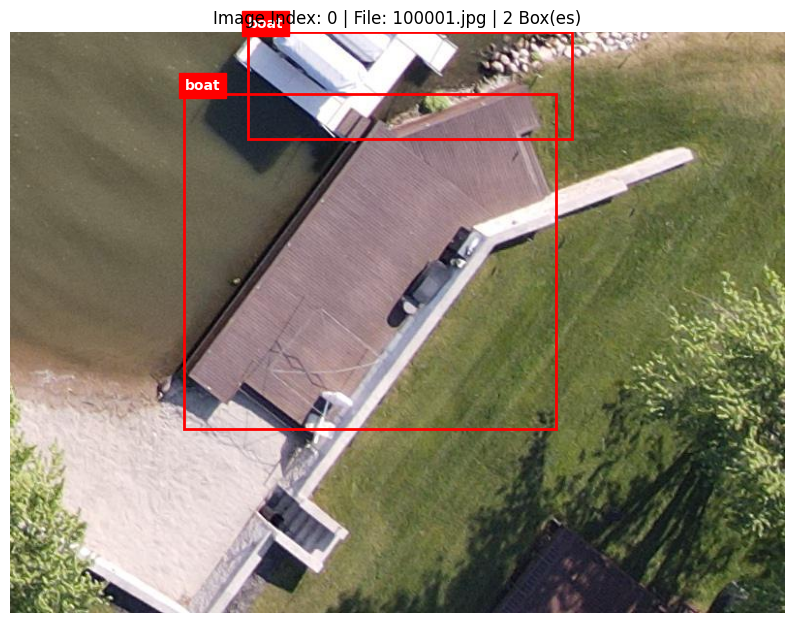

In [ ]:
class_names = ['boat', 'car', 'dock', 'jetski', 'lift']

visualize_sample_with_boxes(
    image_dir="/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/train/images",
    label_dir="/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/train/labels",
    class_names=class_names,
    index=0
)

In [ ]:
def yolo_model(model_path='yolov8n.pt'):
    """
    Load YOLOv8 model

    PARAMS:
    - model_path (str): Path to model weights of the yolov8n.pt

    RETURNS:
    - model (YOLO): Loaded YOLOv8 model.
    """
    model = YOLO(model_path)
    return model

In [ ]:
# Summary of the model
model = yolo_model('yolov8n.pt')
model.info(verbose=True)
print(model.model)

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=Tru

In [ ]:
def yolo_train(model, data_yaml_path, epochs=10, imgsz=640, batch=16, device=None):
  """
  Train YOLO model.

  PARAMS:
  - model (YOLO): YOLO model.
  - data_yaml_path (str): Path to data.yaml
  - epochs (int): Number of epochs
  - imgsz (int): Image size
  - batch (int): Batch size
  - device (int or str): device to train the model
  """
  if device is None:
    device = 0 if torch.cuda.is_available() else "cpu"

  model.train(
      data=data_yaml_path,
      epochs=epochs,
      imgsz=imgsz,
      batch=batch,
      device=device
  )

In [ ]:
def evaluate_yolo(model):
    """
    Evaluate YOLO model.

    RETURNS:
    - metrics (dict): Evaluation results.
    """
    metrics = model.val()

    print("\nEvaluation Metrics:")
    print(f"Mean Precision: {metrics.box.mp:.3f}")
    print(f"Mean Recall: {metrics.box.mr:.3f}")
    print(f"mAP@0.5: {metrics.box.map50:.3f}")
    print(f"mAP@0.5:0.95: {metrics.box.map:.3f}")

    return metrics

In [ ]:
def visualize_yolo_prediction(model, dataset_path, index=0, score_threshold=0.5, class_names=None):
    """
    Visualize predictions (green) and ground truth (red) for YOLO model with class names.

    PARAMS:
    - model (YOLO): YOLO model.
    - dataset_path (str): Path to /test directory.
    - index (int): Index of image to visualize.
    - score_threshold (float): Confidence threshold for predicted boxes.
    - class_names (list[str]): List of class names corresponding to class indices.
    """
    image_dir = Path(dataset_path) / "images"
    label_dir = Path(dataset_path) / "labels"

    img_files = sorted(list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png")))
    img_path = img_files[index]
    label_path = label_dir / (img_path.stem + ".txt")

    # Load image
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Predict
    results = model.predict(source=str(img_path), imgsz=640, conf=score_threshold, save=False)
    preds = results[0]

    # Create figure
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(img)
    ax.set_title(f"YOLO Prediction (Index={index})")

    # Draw predicted boxes (green)
    if preds.boxes is not None:
        for box, score, cls_id in zip(preds.boxes.xyxy.cpu(), preds.boxes.conf.cpu(), preds.boxes.cls.cpu()):
            if score >= score_threshold:
                x1, y1, x2, y2 = box
                class_label = class_names[int(cls_id)] if class_names else str(int(cls_id))
                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='lime', facecolor='none'))
                ax.text(x1, y1 - 5, f"Pred: {class_label} ({score:.2f})", color='lime', fontsize=10, weight='bold')

    # Draw ground truth boxes (red)
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls, x_c, y_c, bw, bh = map(float, line.strip().split())
                x1 = (x_c - bw / 2) * w
                y1 = (y_c - bh / 2) * h
                x2 = (x_c + bw / 2) * w
                y2 = (y_c + bh / 2) * h
                class_label = class_names[int(cls)] if class_names else str(int(cls))
                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='red', facecolor='none'))
                ax.text(x1, y1 - 5, f"GT: {class_label}", color='red', fontsize=10, weight='bold')

    # Add legend
    legend_elements = [
        Line2D([0], [0], color='lime', lw=2, label='Prediction'),
        Line2D([0], [0], color='red', lw=2, label='Ground Truth')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    ax.axis('off')
    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
exp4_path = '/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/data.yaml'
exp4_model = yolo_model('yolov8n.pt')
yolo_train(exp4_model, data_yaml_path=exp4_path, epochs=10)

Using device: cpu


100%|██████████| 6.25M/6.25M [00:00<00:00, 129MB/s]


Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

100%|██████████| 755k/755k [00:00<00:00, 22.0MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    752287  ultralytics.nn.modules.head.Detect           [5, [64, 128, 256]]           
Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.8±0.2 ms, read: 0.2±0.0 MB/s, size: 73.0 KB)


train: Scanning /content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/train/labels.cache... 1435 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1435/1435 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.3 ms, read: 0.2±0.1 MB/s, size: 87.1 KB)


val: Scanning /content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/valid/labels.cache... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.641      3.072      1.591         26        640: 100%|██████████| 90/90 [33:42<00:00, 22.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:13<00:00,  7.32s/it]

                   all        307        962      0.584      0.163      0.303      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.615      2.345      1.584         21        640: 100%|██████████| 90/90 [19:02<00:00, 12.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:12<00:00,  7.22s/it]

                   all        307        962      0.468      0.488      0.417      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G       1.61      2.029      1.586         28        640: 100%|██████████| 90/90 [18:52<00:00, 12.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:10<00:00,  7.05s/it]

                   all        307        962      0.618      0.517      0.566       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.555      1.824      1.565         21        640: 100%|██████████| 90/90 [18:57<00:00, 12.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:13<00:00,  7.35s/it]

                   all        307        962      0.628      0.519      0.536      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.515      1.627      1.523         24        640: 100%|██████████| 90/90 [19:06<00:00, 12.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:09<00:00,  6.91s/it]

                   all        307        962      0.747      0.637       0.69      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.443      1.468      1.482         34        640: 100%|██████████| 90/90 [18:32<00:00, 12.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:06<00:00,  6.68s/it]

                   all        307        962       0.77      0.607      0.682      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.389      1.342       1.43         27        640: 100%|██████████| 90/90 [18:35<00:00, 12.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:07<00:00,  6.76s/it]

                   all        307        962      0.742      0.657      0.739      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.355      1.264      1.412         34        640: 100%|██████████| 90/90 [18:22<00:00, 12.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:07<00:00,  6.73s/it]

                   all        307        962       0.84      0.682      0.784       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.291      1.177       1.38         34        640: 100%|██████████| 90/90 [18:25<00:00, 12.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:09<00:00,  6.99s/it]

                   all        307        962      0.885      0.719       0.81      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.241      1.086      1.348         43        640: 100%|██████████| 90/90 [18:23<00:00, 12.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:11<00:00,  7.14s/it]

                   all        307        962      0.844      0.722      0.825      0.519



10 epochs completed in 3.564 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:04<00:00,  6.42s/it]


                   all        307        962      0.845      0.728      0.825      0.519
                  boat        240        392      0.829      0.703      0.807      0.477
                   car         27         27      0.726      0.689      0.742      0.458
                  dock         24         42      0.968      0.709      0.892      0.606
                jetski         63         90        0.8      0.711      0.799      0.442
                  lift        217        411      0.902      0.827      0.885      0.612
Speed: 5.7ms preprocess, 185.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
metrics = evaluate_yolo(exp4_model)

Ultralytics 8.3.122 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.2 ms, read: 33.7±5.1 MB/s, size: 86.5 KB)


val: Scanning /content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/valid/labels.cache... 307 images, 0 backgrounds, 0 corrupt: 100%|██████████| 307/307 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


                   all        307        962      0.845      0.728      0.825      0.519
                  boat        240        392      0.829      0.703      0.807      0.477
                   car         27         27      0.726      0.689      0.742      0.458
                  dock         24         42      0.968      0.709      0.892      0.606
                jetski         63         90        0.8      0.711      0.799      0.442
                  lift        217        411      0.902      0.827      0.885      0.612
Speed: 1.4ms preprocess, 164.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2

Evaluation Metrics:
Mean Precision: 0.845
Mean Recall: 0.728
mAP@0.5: 0.825
mAP@0.5:0.95: 0.519


In [ ]:
import torch
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
print("torch.cuda.get_device_name(0)" if torch.cuda.is_available() else "No GPU")


torch.cuda.is_available(): False
torch.cuda.device_count(): 0
No GPU



image 1/1 /content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/test/images/100063.jpg: 480x640 2 boats, 3 lifts, 235.2ms
Speed: 4.4ms preprocess, 235.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


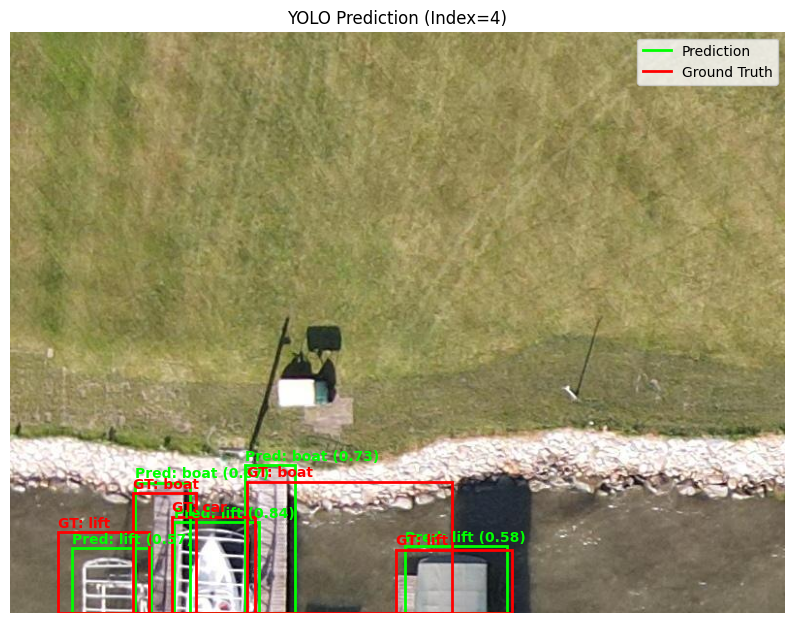

In [ ]:
class_names = ['boat', 'car', 'dock', 'jetski', 'lift']
visualize_yolo_prediction(exp4_model, dataset_path=f'/content/drive/MyDrive/42028AUT2025/Assignment2/dataset/Object_Detection/yolo/test', index=4, score_threshold=0.3, class_names=class_names)